# Empirical Proof for Motif Calling
This notebook demonstrates the superiority of calling at motif level as compared to calling at base level. First, we explain the dataset and the squiggle values. Then we split to train and test sets to learn the motifs that were identified. We then compare that performance to strict basecalling followed by a motif search algorithm and compare their performances.

# Motif Calling

### Motif Sequences for the Emprirical Experiment

| Sr No. | Sequence Name | Sequence |
|--------|---------------|----------|
| 1 | _1 | AACAACATCAATCCTACATCGCCTA |
| 2 | _2 | ATATACCTCGCCTCATCTCAATCAA |
| 3 | _3 | TTTCACTTCTTATCCGCCTCACCTA |
| 4 | _4 | CACCTTCACCTTACCTACTCAATTC |
| 5 | _5 | CAACCCTCTATCCGCCTCTCCACTA |
| 6 | _6 | AACCCATCACTTACCTCTCTTAACA |
| 7 | _7 | CCATCCATATCATTTTCTCCTTACC |
| 8 | _8 | CCACATCTACCCTTCCACTCTATCA |

So the label becomes a 21 one hot encoded vector that has 8 1s in it which are the motifs that were detected.

## Dataset Exploration and Cleaning

The Dataset consists of a Squiggle - which is an array of Double Values of length ranging to about 10,000 and the corresponding motifs that were identified in that squiggle. The squiggle corresponds to the value of the electrical current deviation as the base pair of the DNA strand passes through the nucleotide. The motif library is shown above. Let us go through the dataset now.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("dataset_motif_level.pkl")
df.head()

,squiggle,motifs
0,"[[671, 498, 504, 526, 502, 512, 527, 528, 517,...",ltm8_1x1|ltm8_2x1|ltm8_4x2|ltm8_5x7|ltm8_6x4|l...
1,"[[540, 415, 425, 463, 470, 494, 499, 498, 494,...",ltm8_2x1|ltm8_3x4|ltm8_6x8|ltm8_7x2|ltm8_7x2|l...
2,"[[899, 851, 806, 779, 729, 713, 673, 659, 632,...",ltm8_2x1|ltm8_4x8|ltm8_5x1|ltm8_6x7|ltm8_7x1|l...
3,"[[522, 513, 517, 522, 515, 503, 518, 523, 524,...",ltm8_1x1|ltm8_2x1|ltm8_3x5|ltm8_4x1|ltm8_5x6|l...
4,[],ltm8_2x1|ltm8_4x7|ltm8_5x4|ltm8_6x4|ltm8_6x7|l...


### Getting rid of the missing values

In [3]:
# Get the number of missing values in squiggles and drop those columns
squiggles = df['squiggle'].to_numpy()
motifs = df['motifs'].to_numpy()
counter = 0
squiggles_ = []
label_ = []

for i in range(len(squiggles)):
    if len(squiggles[i]) != 0:
        squiggles_.append(squiggles[i][0])
        label_.append(motifs[i])

print(len(squiggles_))
print(len(label_))


8006
8006


### Padding inputs to the Same Length

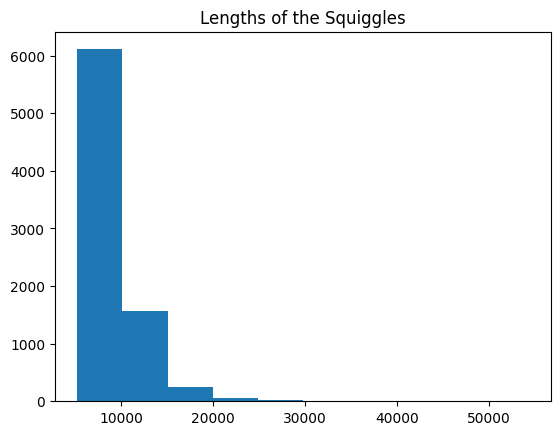

In [4]:
lengths = [len(i) for i in squiggles_]

plt.hist(lengths)
plt.title("Lengths of the Squiggles")
plt.show()

In [5]:
max(lengths)

54295

In [6]:
np.mean(lengths)

9229.132025980514

In [7]:
np.std(lengths)

3097.7734380883594

In [8]:
len([i for i in lengths if i > 15000])

338

In [9]:

X = []
y = []

for i in range(len(squiggles_)):
    if len(squiggles_[i]) < 13000:
        X.append(squiggles_[i])
        y.append(label_[i])

print(len(X))
print(len(y))

7278
7278


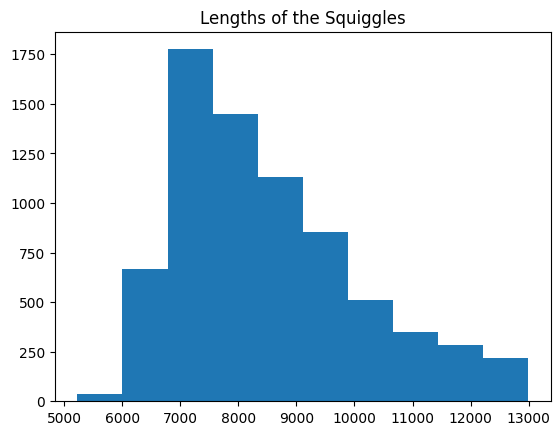

In [10]:
lengths = [len(i) for i in X]

plt.hist(lengths)
plt.title("Lengths of the Squiggles")
plt.show()

In [11]:

# Padding to a length of 13k
for i in range(len(X)):
    X[i] = np.append(X[i], np.zeros(13000 - len(X[i])))


In [12]:
lengths = [len(i) for i in X]
print(np.mean(lengths))
print(np.std(lengths))

13000.0
0.0


### One Hot Encoding the Label

Need to correspond the motif locations with the decoded consensus and then convert to the type of motif sequence so that we can have a one hot encoded label. Let's get it done.

So

ltm8_3x4 - first index represents the location in the cycle and the second represents the motif (so in this case 1 and 4, since first 2 are payloads)

We don't care about the payload locations (yet) so we can simply get the motifs that were identified, even though it is about half the signal.

In [13]:

y_ = []
for i in y:
    motif_freqs = np.zeros(8, dtype=int)
    motifs_detected = [int(t[-1]) for t in i.split('|')]
    for motif in motifs_detected:
        motif_freqs[motif-1] += 1
    y_.append(motif_freqs)

y = y_
print(y[:10])



[array([2, 1, 0, 1, 2, 1, 1, 0]), array([2, 2, 0, 1, 2, 0, 0, 1]), array([3, 1, 0, 1, 0, 0, 2, 1]), array([4, 0, 0, 0, 1, 2, 1, 0]), array([1, 1, 0, 1, 2, 0, 2, 1]), array([3, 0, 0, 1, 0, 1, 0, 3]), array([2, 1, 1, 1, 0, 2, 1, 0]), array([2, 2, 2, 0, 1, 0, 1, 0]), array([2, 0, 2, 2, 0, 1, 0, 1]), array([1, 3, 1, 0, 0, 1, 0, 2])]


In [14]:
print(X[:10], y[:10])


[array([671., 498., 504., ...,   0.,   0.,   0.]), array([540., 415., 425., ...,   0.,   0.,   0.]), array([899., 851., 806., ...,   0.,   0.,   0.]), array([522., 513., 517., ...,   0.,   0.,   0.]), array([538., 458., 451., ...,   0.,   0.,   0.]), array([388., 369., 443., ...,   0.,   0.,   0.]), array([595., 590., 576., ...,   0.,   0.,   0.]), array([398., 382., 452., ...,   0.,   0.,   0.]), array([634., 478., 501., ...,   0.,   0.,   0.]), array([569., 465., 477., ...,   0.,   0.,   0.])] [array([2, 1, 0, 1, 2, 1, 1, 0]), array([2, 2, 0, 1, 2, 0, 0, 1]), array([3, 1, 0, 1, 0, 0, 2, 1]), array([4, 0, 0, 0, 1, 2, 1, 0]), array([1, 1, 0, 1, 2, 0, 2, 1]), array([3, 0, 0, 1, 0, 1, 0, 3]), array([2, 1, 1, 1, 0, 2, 1, 0]), array([2, 2, 2, 0, 1, 0, 1, 0]), array([2, 0, 2, 2, 0, 1, 0, 1]), array([1, 3, 1, 0, 0, 1, 0, 2])]


We now have an array of doubles representing the squiggle and an array of frequency of motifs detected within the signal as the label - let us do a forward pass of the network to see what we get!

## The Model

In [15]:


import torch
import torch.nn as nn


class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)

class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


In [16]:
##### input_length = 20000 # Length of longest squiggle


"""
class MotifModel(nn.Module):

    def __init__(self
"""


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

SpeechRecognitionModel(1,3,200,4,20)

SpeechRecognitionModel(
  (cnn): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (rescnn_layers): Sequential(
    (0): ResidualCNN(
      (cnn1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (cnn2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (layer_norm1): CNNLayerNorm(
        (layer_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      )
      (layer_norm2): CNNLayerNorm(
        (layer_norm): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (fully_connected): Linear(in_features=320, out_features=200, bias=True)
  (birnn_layers): Sequential(
    (0): BidirectionalGRU(
      (BiGRU): GRU(200, 200, batch_first=True, bidirectional=True)
      (layer_norm): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Bidirectional

### Simulating Forward Pass of the Model with the data

### CNN Feature Extraction

In [17]:
import torch
import torch.nn as nn

In [18]:
# Define the input tensor
input_array = torch.randn(13000)  # (sequence_length)
batch_size = 1
input_size = 1
sequence_length = input_array.size(0)

# Reshape the input array into a 3D tensor
input_tensor = input_array.view(batch_size, input_size, sequence_length)

#1D CNN layer
class Conv1D(nn.Module):

    def __init__(self):
        super(Conv1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool(x)
        return x

conv_model = Conv1D()
conv_model

Conv1D(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [19]:
output = conv_model(input_tensor)
output.shape

torch.Size([1, 64, 3250])

### Fully Connected Layers

In [34]:
import torch
import torch.nn as nn

class CNN_BiGRU_Classifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(CNN_BiGRU_Classifier, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1)
        self.norm1 = nn.LayerNorm(32)
        self.drop1 = nn.Dropout(dropout_rate)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm2 = nn.LayerNorm(64)
        self.drop2 = nn.Dropout(dropout_rate)

        # Fully connected layer
        self.fc = nn.Linear(64, hidden_size)

        # Bidirectional GRU layers
        self.bigru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)

        # Sequence classifier
        self.output = nn.Linear(hidden_size * 2, output_size)

        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        # Permute the input tensor to (batch_size, channels, sequence_length)

        # CNN layers
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.drop1(x)
        x = self.pool(x)

        # Apply LayerNorm after permuting the dimensions
        #x = x.permute(0, 2, 1)
        #x = self.norm1(x)

        x = self.conv2(x)
        #x = self.norm2(x)
        x = torch.relu(x)
        x = self.drop2(x)

        # Fully connected layer
        x = x.permute(0, 2, 1)
        x = self.fc(x)

        # Bidirectional GRU layers
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size)
        x, _ = self.bigru(x, h0)

        # Output layer
        x = self.output(x)

        # Summing across sequence length - btw this can be used for aligning as well
        x = x.sum(dim=1)

        return x

# Example usage
input_size = 1  # Number of input channels
hidden_size = 128
num_layers = 2
output_size = 8  # Number of output classes
dropout_rate = 0.2

model = CNN_BiGRU_Classifier(input_size, hidden_size, num_layers, output_size, dropout_rate)
# Define the input tensor
input_array = torch.randn(13000)  # (sequence_length)
batch_size = 1
input_size = 1
sequence_length = input_array.size(0)

# Reshape the input array into a 3D tensor
input_tensor = input_array.view(batch_size, input_size, sequence_length)
output = model(input_tensor)
#print(output.shape)

Got to make the input sizes compatible with each other - gotta write it with pen and figure it out

In [21]:
output

tensor([[ -89.9399,  -96.6463,   88.6385,  566.2605,   -0.8596, -267.6644,
           -9.8011, -393.9146]], grad_fn=<SumBackward1>)

In [22]:
output.shape

torch.Size([1, 8])

In [23]:
import torch.nn.functional as F
target = torch.tensor([[2, 0, 1, 1, 2, 0, 1, 1]]) # Example target tensor

loss = F.mse_loss(output, target.float())

In [24]:
loss

tensor(71590.0078, grad_fn=<MseLossBackward0>)

## Training


Splitting into training, validation and testing

In [25]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming X and y are numpy arrays
X = np.array(X)
y = np.array(y)

# Split the data into train, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Creating Pytorch Datasets and DataLoaders that automatically batch and optimise training

In [26]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Difference between validation and testing?

In [27]:
X_train_tensor

tensor([[ 647.,  484.,  505.,  ...,    0.,    0.,    0.],
        [ 483.,  547.,  505.,  ...,    0.,    0.,    0.],
        [ 363.,  384.,  404.,  ...,    0.,    0.,    0.],
        ...,
        [ 535.,  513.,  484.,  ...,    0.,    0.,    0.],
        [ 473.,  503.,  510.,  ...,    0.,    0.,    0.],
        [1031., 1023.,  781.,  ...,    0.,    0.,    0.]])

Defining Training Loop and Training

In [28]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [33]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

from tqdm import tqdm
import torch
import torch.nn.functional as F

import torch.optim as optim
from tqdm import tqdm


torch.set_default_device(device)

model = CNN_BiGRU_Classifier(input_size, hidden_size, num_layers, output_size, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = np.inf


# Training loop
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    for input_sequence, target in (train_loader):
        input_sequence = input_sequence.to(device)
        target = target.to(device)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass
        try:
          input_sequence = input_sequence.view(batch_size, input_size, sequence_length)
          output = model(input_sequence)
          # Compute the loss
          loss = criterion(output, target)
          print(loss)
          # Backpropagation
          loss.backward()

          # Update the weights
          optimizer.step()
        except Exception as e:
          print(e)



    # Validation loop
    model.eval()
    val_loss = 0
    for input_sequence, target in val_loader:
      try:
        input_sequence = input_sequence.to(device)
        target = target.to(device)
        input_sequence = input_sequence.view(batch_size, input_size, sequence_length)
        output = model(input_sequence)
        val_loss += criterion(output, target).item()
      except Exception as e:
        print(e)
    val_loss /= len(val_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

    # Model checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

Running on cuda:0


  0%|                                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  1%|█▋                                                                                                                                                                         | 1/100 [00:00<00:58,  1.70it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  2%|███▍                                                                                                                                                                       | 2/100 [00:00<00:43,  2.23it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  3%|█████▏                                                                                                                                                                     | 3/100 [00:01<00:38,  2.53it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  4%|██████▊                                                                                                                                                                    | 4/100 [00:01<00:35,  2.74it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  5%|████████▌                                                                                                                                                                  | 5/100 [00:01<00:33,  2.85it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 221000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  6%|██████████▎                                                                                                                                                                | 6/100 [00:02<00:32,  2.89it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 208000
Epoch [6/100],

  7%|███████████▉                                                                                                                                                               | 7/100 [00:02<00:35,  2.64it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  8%|█████████████▋                                                                                                                                                             | 8/100 [00:03<00:38,  2.39it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

  9%|███████████████▍                                                                                                                                                           | 9/100 [00:03<00:35,  2.53it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

 10%|█████████████████                                                                                                                                                         | 10/100 [00:03<00:33,  2.67it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

 11%|██████████████████▋                                                                                                                                                       | 11/100 [00:04<00:31,  2.78it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

 12%|████████████████████▍                                                                                                                                                     | 12/100 [00:04<00:30,  2.89it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 221000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

 13%|██████████████████████                                                                                                                                                    | 13/100 [00:04<00:29,  2.95it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

 14%|███████████████████████▊                                                                                                                                                  | 14/100 [00:05<00:29,  2.96it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

 15%|█████████████████████████▌                                                                                                                                                | 15/100 [00:05<00:30,  2.82it/s]

shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

 15%|█████████████████████████▌                                                                                                                                                | 15/100 [00:05<00:32,  2.61it/s]


shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 13000]' is invalid for input of size 416000
shape '[1, 1, 

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

Seems to be one mismatched training example which is a thorn in my side

VAMOS validation loss goes down, we in buisness babbbyyy